## Задание №2. Медианный фильтр

In [69]:
import numpy as np
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt

Обычный питон работает очень долго, поэтому воспользуемся numba.
Единственная сложность с ней заключается в том, что numpy функции с ней не работают и придется написать тот же паддинг самому.

In [71]:
from numba import njit, prange, set_num_threads
set_num_threads(12)

In [79]:
@njit
def get_padded_image(image, paddind_size):
    result = np.zeros((image.shape[0] + 2 * paddind_size, image.shape[1] + 2 * paddind_size, image.shape[2]))
    
    for i in prange(image.shape[0] + 2 * paddind_size):
        for j in prange(image.shape[1] + 2 * paddind_size):
            result[i, j, :] = image[0 if (i < paddind_size) else (image.shape[0] - 1 if i >= image.shape[0] + paddind_size else i - paddind_size), 
                                    0 if (j < paddind_size) else (image.shape[1] - 1 if j >= image.shape[1] + paddind_size else j - paddind_size), :]
            
    return result

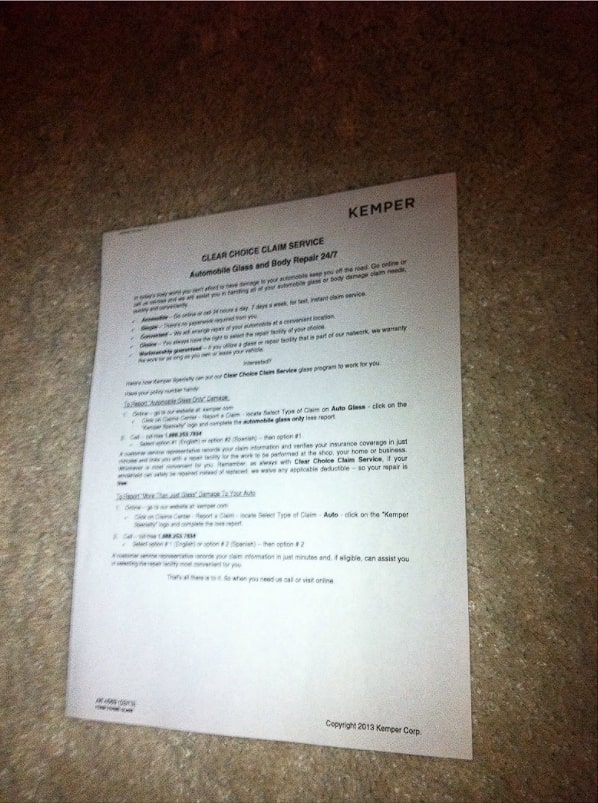

In [75]:
image = Image.open("first_image.jpg")
display(image)

In [76]:
image = np.asarray(image)
R = 5

#### Замечание
В документации OpenCV указано, что каждый канал изображения обрабатывается независимо, поэтому реализованные фильтры будут работать аналогично (альтернативно можно было сортировать пиксели по совокупной яркости пикселя).

### Метод №1: простая сортировка

In [80]:
@njit(parallel=True)
def median_filter_with_simple_sort(image, R):
    padded_image = get_padded_image(image, R)
    result = np.zeros_like(image)

    for i in prange(R, padded_image.shape[0] - R):
        for j in prange(R, padded_image.shape[1] - R):
            window = padded_image[i - R : i + R +1, j - R : j + R + 1].copy().reshape(-1, 3)
            for channel in prange(3):
                window[:, channel]=np.sort(window[:, channel])
            result[i - R, j - R] = window[len(window) // 2]
            
    return result
            

Сложность : $O(R^2 \log{R})$ 

Дополнительная память : $O(R^2)$ 

Замечание : здесь и далее без учета копии с паддингом, можно было бы сделать in-place, но при этом все равно была бы реаллокация. С учетом того, что это не так критично решил не реализовывать.

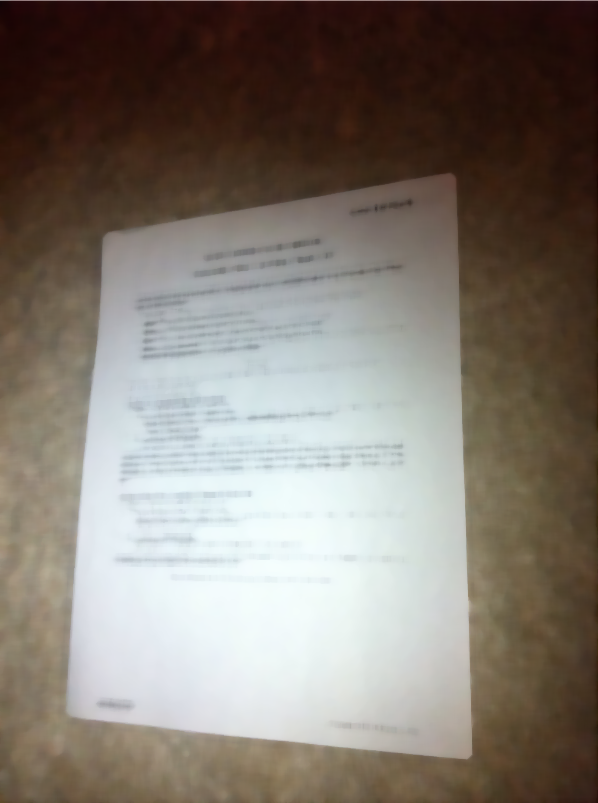

In [81]:
first_result = median_filter_with_simple_sort(image, R)
Image.fromarray(first_result)

### Метод №2: алгоритм Huang

In [86]:
@njit
def get_histogram_median(histogram):
    cumsum = np.cumsum(histogram.reshape(-1))
    total_sum = cumsum[-1]
    
    for i in range(len(cumsum)):
        if cumsum[i] >= total_sum // 2 + 1:
            return i

In [87]:
@njit(parallel=True)
def median_filter_huang(image, R):
    padded_image = get_padded_image(image, R)
    result = np.zeros_like(image)

    for i in prange(R, padded_image.shape[0] - R):
        for channel in prange(3):
            histogram = np.histogram(padded_image[i - R : i + R + 1, : 2 * R + 1, channel], bins = 256, range = (0, 255))[0]
            for j in prange(R, padded_image.shape[1] - R):
                result[i - R, j - R, channel] = get_histogram_median(histogram)
                if j != padded_image.shape[1] - R - 1:
                    histogram -= np.histogram(padded_image[i - R : i + R + 1, j - R, channel], bins = 256, range = (0, 255))[0]
                    histogram += np.histogram(padded_image[i - R : i + R + 1, j + R + 1, channel], bins = 256, range = (0, 255))[0]

    return result
            

Сложность : $O(R)$ 

Дополнительная память : $O(N)$, где N - количество каналов для хранения гистограммы

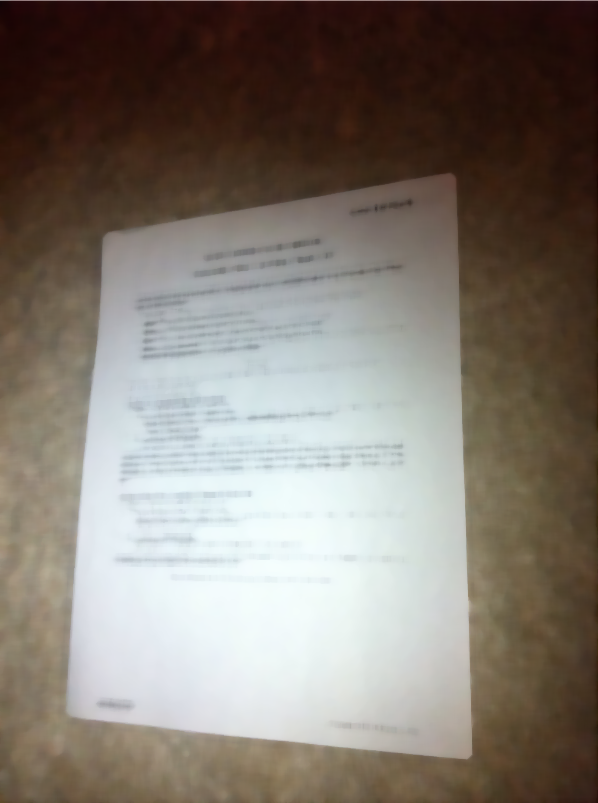

In [88]:
second_result = median_filter_huang(image, R)
Image.fromarray(second_result)

### Метод №3: константный

In [89]:
@njit(parallel=True)
def median_filter_const(image, R):
    padded_image = get_padded_image(image, R)
    result = np.zeros_like(image)

    for channel in prange(3):
        histograms = []
        histograms.append(np.histogram(padded_image[:2 * R + 1, :2 * R + 1, channel], bins = 256, range = (0, 255))[0])
        for j in prange(R, padded_image.shape[1] - R - 1):
            next_hist = histograms[-1] - np.histogram(padded_image[:2 * R + 1, j - R, channel], bins = 256, range = (0, 255))[0] +\
                                         np.histogram(padded_image[:2 * R + 1, j + R + 1, channel], bins = 256, range = (0, 255))[0]
            histograms.append(next_hist)
            
        for i in prange(R, padded_image.shape[0] - R):
            for j in prange(R, padded_image.shape[1] - R):
                result[i - R, j - R, channel] = get_histogram_median(histograms[j - R])
                if i != padded_image.shape[0] - R - 1:
                    histograms[j - R] -= np.histogram(padded_image[i - R, j - R : j + R + 1, channel], bins = 256, range = (0, 255))[0]
                    histograms[j - R] += np.histogram(padded_image[i + R + 1, j - R : j + R + 1, channel], bins = 256, range = (0, 255))[0]

    return result
            

Сложность : $O(1)$ 

Дополнительная память : $O(N * W)$, где $N$ - количество каналов, $W$ - ширина изображения

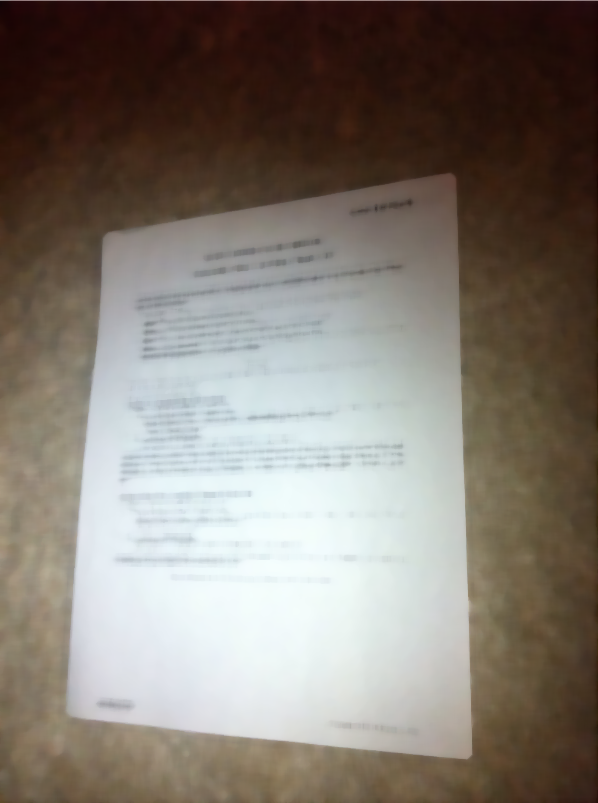

In [90]:
third_result = median_filter_const(image, R)
Image.fromarray(third_result)

### Сравнение

In [91]:
import time

In [92]:
def get_median_filter_time(method, image, R):
    megapixel_count = image.shape[0] * image.shape[1] / 10 ** 6
    start_time = time.time()
    median_filter = method(image, R)
    return (time.time() - start_time) * 1000 / megapixel_count

In [101]:
cv_time = []
simple_sort_time = []
huang_time = []
constant_time = []

for R in range(1, 57):
    cv_time.append(get_median_filter_time(cv.medianBlur, image, 2 * R + 1))
    simple_sort_time.append(get_median_filter_time(median_filter_with_simple_sort, image, R))
    huang_time.append(get_median_filter_time(median_filter_huang, image, R))
    constant_time.append(get_median_filter_time(median_filter_const, image, R))

57


KeyboardInterrupt: 

Text(0.5, 1.0, 'Зависимость времени работы от размера окна фильтра')

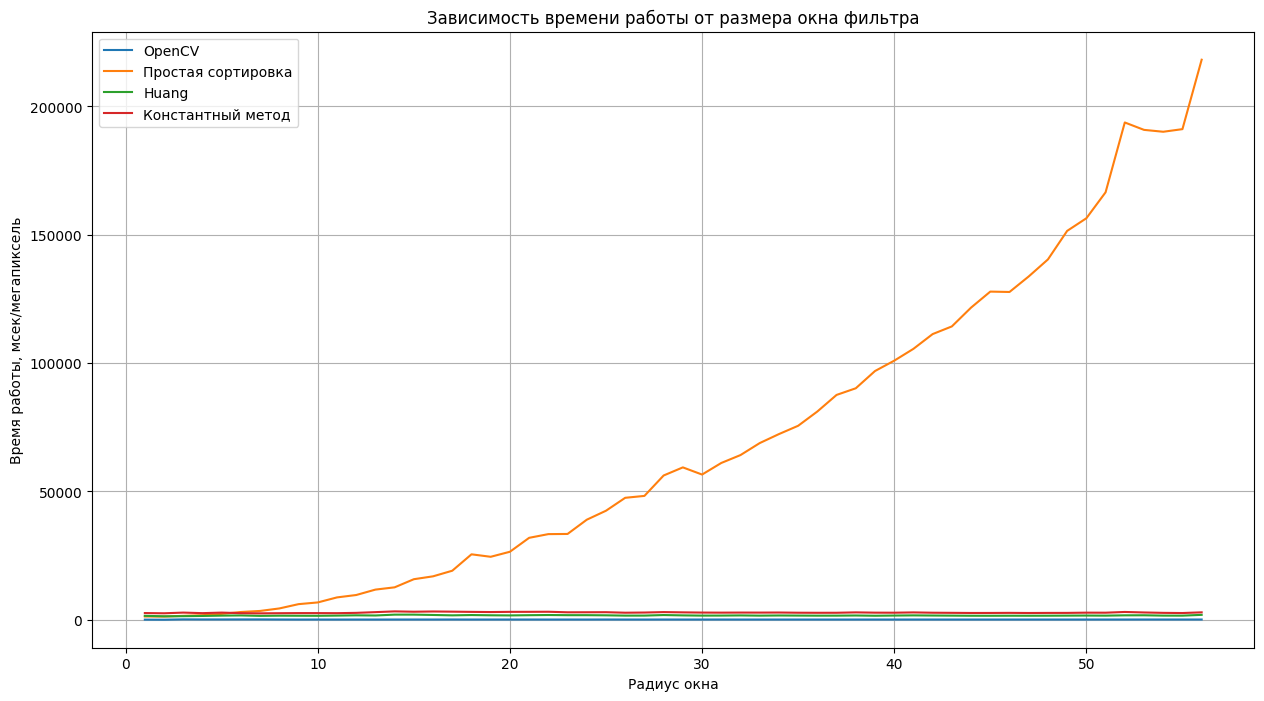

In [98]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, 57), cv_time, label='OpenCV')
plt.plot(np.arange(1, 57), simple_sort_time, label='Простая сортировка')
plt.plot(np.arange(1, 57), huang_time, label='Huang')
plt.plot(np.arange(1, 57), constant_time, label='Константный метод')

plt.xlabel('Радиус окна')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.grid()
plt.legend()
plt.title('Зависимость времени работы от размера окна фильтра')

Text(0.5, 1.0, 'Зависимость времени работы от размера окна фильтра')

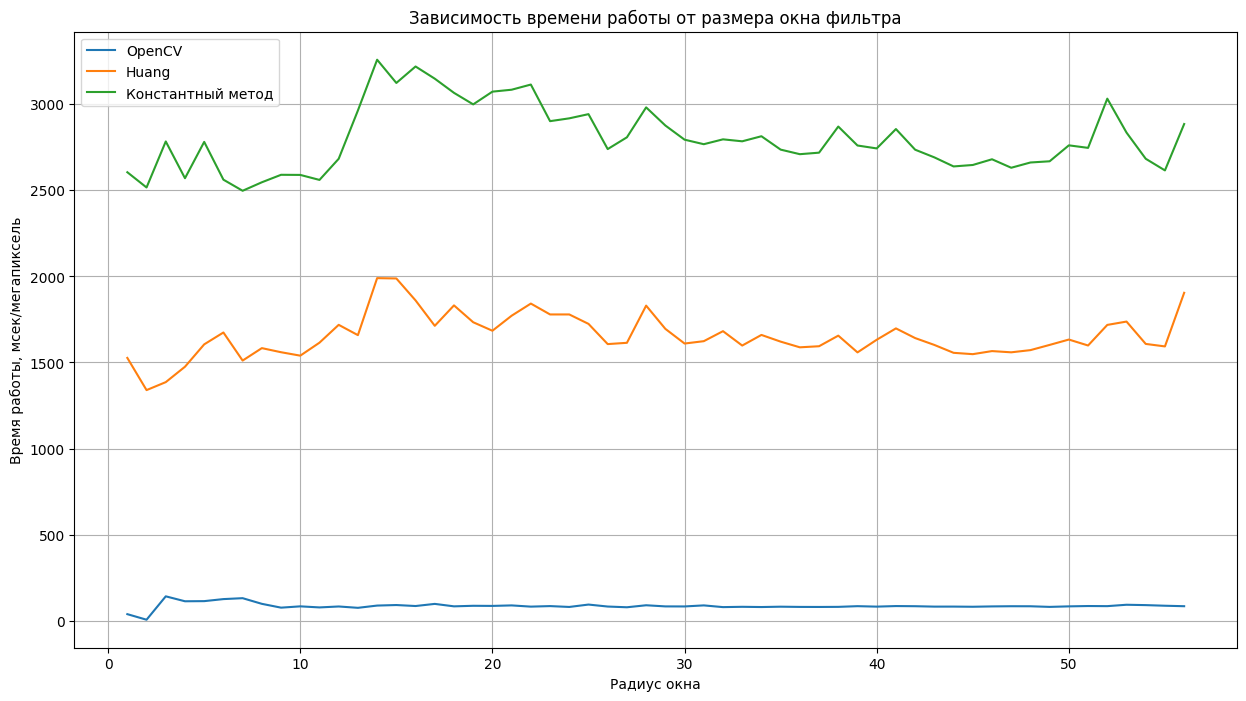

In [100]:
# график без алгоритма с простой сортировкой, т.к. он наиболее долгий
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, 57), cv_time, label='OpenCV')
plt.plot(np.arange(1, 57), huang_time, label='Huang')
plt.plot(np.arange(1, 57), constant_time, label='Константный метод')

plt.xlabel('Радиус окна')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.grid()
plt.legend()
plt.title('Зависимость времени работы от размера окна фильтра')

Text(0.5, 1.0, 'Зависимость времени работы от радиуса окна')

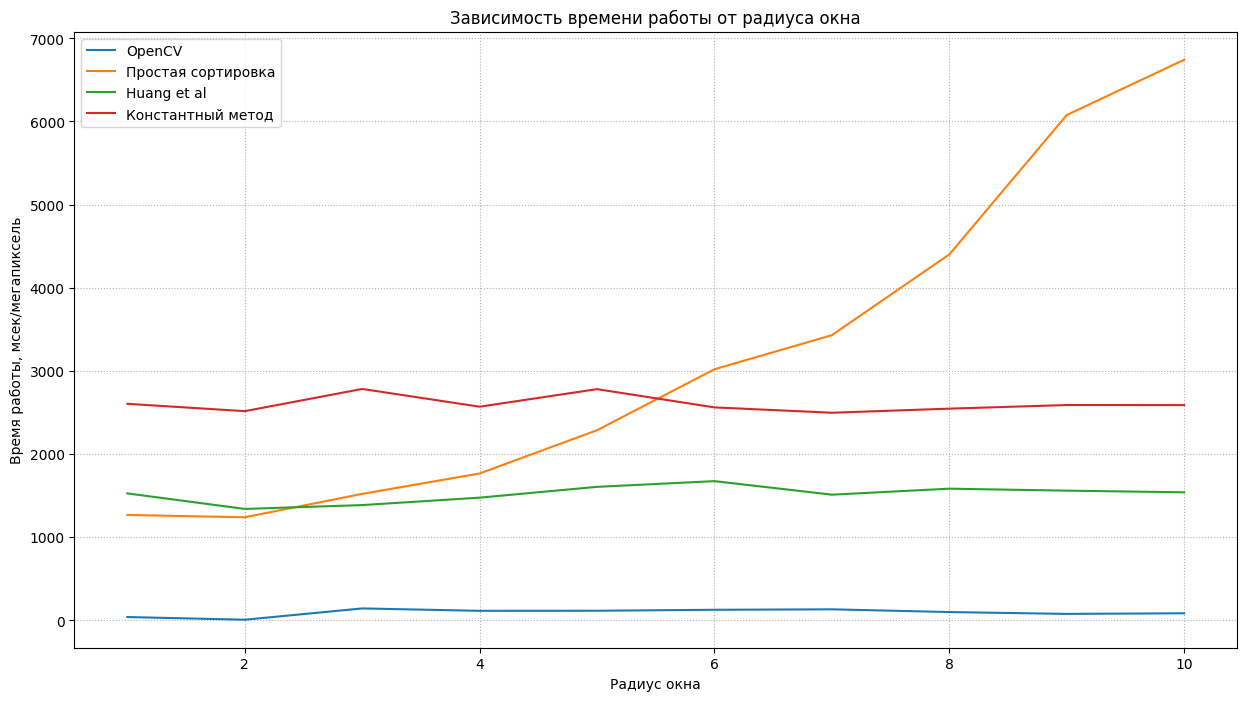

In [105]:
# рассмотрим малые значения
plt.figure(figsize=(15, 8))
plt.plot(np.arange(1, 11), cv_time[:10], label='OpenCV')
plt.plot(np.arange(1, 11), simple_sort_time[:10], label='Простая сортировка')
plt.plot(np.arange(1, 11), huang_time[:10], label='Huang et al')
plt.plot(np.arange(1, 11), constant_time[:10], label='Константный метод')

plt.xlabel('Радиус окна')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.grid(ls=':')
plt.legend()
plt.title('Зависимость времени работы от радиуса окна')

### Анализ результатов и вывод

Наиболее быстрым является алгоритм реализованный в библиотеке OpenCV.

Для реализованных алгоритмов видим, что при R<3, выгоднее использовать алгоритм с простой сортировкой, а при больших значениях Huang. Константный алгоритм является самым медленным при всех значениях R, т.к. имеет достаточно большую константу и вероятно сможет лучше себя проявить на горизонтальных изображениях, но это нужно уже отдельно исследовать.